In [139]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [140]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/8083/genetherapy.csv')

In [141]:
df.head()

,expr,Therapy
0,100,A
1,96,A
2,101,A
3,95,A
4,103,A


In [142]:
therapy_A_df = df.query("Therapy=='A'")
therapy_B_df = df.query("Therapy=='B'")
therapy_C_df = df.query("Therapy=='C'")
therapy_D_df = df.query("Therapy=='D'")

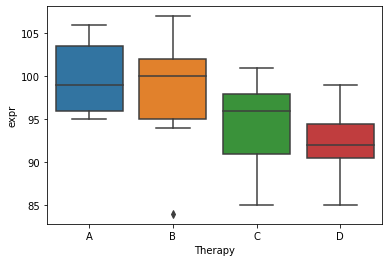

In [143]:
ax = sns.boxplot(x='Therapy', y='expr', data=df)

H0 - все средние экспрессии групп равны, H1 - хотя бы одна группа имеет стат значимое отличие

In [144]:
mean_expr = df.expr.mean() #среднее значение экспрессии по всем группам

In [145]:
# общая сумма квадратов (общая изменчивость) - square summ total
SST = pow(df.expr - mean_expr, 2).sum()
degress_of_freedom = df.expr.size - 1

n1, n2 = therapy_A_df.expr.size, therapy_B_df.expr.size
n3, n4 = therapy_C_df.expr.size, therapy_D_df.expr.size

mean_expr_A = therapy_A_df.expr.mean()
mean_expr_B = therapy_B_df.expr.mean()
mean_expr_C = therapy_C_df.expr.mean()
mean_expr_D = therapy_D_df.expr.mean()

# межгрупповая изменчивость - summ of square between groups
SSB = n1 * pow(mean_expr_A - mean_expr, 2) + n2 * pow(mean_expr_B - mean_expr, 2) + n3 * pow(mean_expr_C - mean_expr, 2) + n4 * pow(mean_expr_D - mean_expr, 2)
df_SSB = 3

# внутригрупповая изменчивость - ... within groups
SSW = pow(therapy_A_df.expr - mean_expr_A, 2).sum()\
    + pow(therapy_B_df.expr - mean_expr_B, 2).sum()\
    + pow(therapy_C_df.expr - mean_expr_C, 2).sum()\
    + pow(therapy_D_df.expr - mean_expr_D, 2).sum()
df_SSW = df.expr.size - 4

In [146]:
if SST -( SSB + SSW) < 10e-13 == False:
    print('error')

In [147]:
SSB, SSW, df_SSW, therapy_B_df.expr.size

(560.7166666666667, 1302.2666666666669, 56, 15)

In [148]:
# межгрупповой и внутригрупповой средние квадраты
MS_bg = SSB / df_SSB
MS_wg = SSW / df_SSW

# критерий Фишера
F_value = MS_bg / MS_wg

In [149]:
F_value

8.037302481143987

In [150]:
# для 95 % ДИ p-value = 0.002 < 0.05 -> отклоняем H0

In [151]:
# вариант с использованием библиотеки scipy
import scipy.stats as stats

fvalue, pvalue = stats.f_oneway(therapy_A_df.expr, therapy_B_df.expr, therapy_C_df.expr, therapy_D_df.expr)
print(fvalue, pvalue)

8.03730248114399 0.00015249722895229536


p-value < 0.05 -> отклоняем H0

In [152]:
# вариант с использованием библиотеки sctatsmodels и таблицей anova
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('expr ~ C(Therapy)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Therapy),560.716667,3.0,8.037302,0.000152
Residual,1302.266667,56.0,NaN,NaN


sum_sq: C(Therapy) - SSB, Residual - SSW

df: C(Therapy) - df_SSB, Residual - df_SSW

In [153]:
from itertools import zip_longest # for Python 3.x
import statistics

def grouper(n, iterable, padvalue=None):
    "grouper(3, 'abcdefg', 'x') --> ('a','b','c'), ('d','e','f'), ('g','x','x')"
    return list(zip_longest(*[iter(iterable)]*n, fillvalue=padvalue))

In [161]:
# с помощью перестановочного теста

#наблюдаемая дисперсия между средними значениями в группах
cur_variance = statistics.variance([mean_expr_A, mean_expr_B, mean_expr_C, mean_expr_D])

variances = []
ind = list(range(df.expr.size))

for i in range(100000):
    # вынимаем 4 повторные выборки (4 вида терапии) 
    random.shuffle(ind)
    grouped_ind = grouper(int(df.expr.size/4), ind)
    grouped_ind = list(map(lambda x: list(x), grouped_ind))
    # записываем среднее значение каждой из 4 групп
    means = [df.expr[grouped_ind[0]].mean(), df.expr[grouped_ind[1]].mean(), df.expr[grouped_ind[2]].mean(), df.expr[grouped_ind[3]].mean()]
    # записываем дисперсию среди средних значений 5 групп
    variances.append(statistics.variance(means))

    
# смотрим какую долю случаев повторно опробованная дисперсия превышала наблюдаемую дисперсию? - это p-value
variances = np.array(variances)

p_value = len(np.where(variances >=cur_variance)[0]) / len(variances)
p_value
    
# или можем записывать не дисперсию а считать для каждого раза F

0.00015

Значение получилось очень близким к вычисленным раннее. Однако цикл for замедляет работу.

In [259]:
ind = np.arange(df.expr.size) #создать 100000 одинковых массивов
ind = np.tile(ind, (100000, 1))
np.apply_along_axis(np.random.shuffle,1,ind) 
#np.apply_along_axis(np.reshape(4, 15), 0, ind)
ind

array([[ 3, 43, 36, ..., 59, 55, 19],
       [18, 57, 41, ..., 26, 36, 14],
       [47, 51, 28, ..., 17, 49, 40],
       ...,
       [ 4, 53, 32, ...,  6, 24,  8],
       [32,  3, 59, ..., 13, 21, 23],
       [ 3, 20, 30, ..., 28,  0,  5]])

In [288]:
values = df.expr.values
values = np.tile(values, (100000, 1))
np.apply_along_axis(np.random.shuffle,1,values)
values

array([[106, 103, 106, ..., 106,  87, 100],
       [101, 100,  91, ...,  98, 106,  96],
       [ 98,  90,  98, ..., 106,  96,  99],
       ...,
       [ 99, 105,  96, ...,  92, 104,  95],
       [106,  90,  96, ...,  98,  95,  96],
       [ 95,  97,  95, ...,  93,  99,  94]])

In [285]:
#теперь разбить кажду строку на 4 группы, посчитать в них среднее и дисперсию
#values[0].reshape(4, 15)
values.reshape(100000, 4, 15)

#np.apply_along_axis(np.reshape(4, 15),1,values)

array([[[ 93,  85,  95, ...,  95,  85,  89],
        [105,  97,  90, ...,  85, 105,  96],
        [ 98, 103, 101, ..., 106, 101,  96],
        [ 84,  95,  94, ...,  91,  95,  99]],

       [[ 93,  92,  91, ..., 103, 101, 105],
        [ 96, 100,  94, ...,  96,  95,  94],
        [ 91,  97, 106, ..., 100,  94, 103],
        [ 95,  90,  96, ...,  95,  95,  90]],

       [[101,  94,  96, ...,  85,  98, 101],
        [ 99, 100,  94, ...,  91,  89,  95],
        [ 90,  94,  95, ...,  96,  91,  85],
        [ 94, 104,  90, ...,  97,  92,  95]],

       ...,

       [[ 98,  95,  89, ..., 101, 100,  93],
        [106,  96,  97, ...,  95, 106,  94],
        [ 95,  99,  94, ..., 101,  91, 103],
        [100,  97, 100, ..., 105,  91,  84]],

       [[100, 105, 107, ...,  95, 100,  97],
        [ 95,  92,  95, ...,  91,  91,  98],
        [ 85, 101, 100, ...,  92, 100,  95],
        [ 97,  99, 103, ...,  98,  95,  84]],

       [[ 95,  95,  96, ...,  94,  96,  95],
        [ 84,  99,  99, ...,  85

In [290]:
values[0].sum(axis=0)

5779

In [284]:
#print(ind[0])
#ind[0].reshape(4, 15)
a = np.arange(12).reshape((2, 6))
print(a)
b = a.reshape((2,3,2))
print('new')
print(b)

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]]
new
[[[ 0  1]
  [ 2  3]
  [ 4  5]]

 [[ 6  7]
  [ 8  9]
  [10 11]]]


In [22]:
def get_bootstrap_samples(data, n_samples):
    '''Генерирует заданное кол-во (n_samples) выборок, равных по размеру исходной выборке'''
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    #print(indices)
    samples = data[indices]
    return samples

In [43]:
set1 = {"a", "b", "c", "d", "e"}
print("With set:", random.sample(set1, 2))

With set: ['e', 'b']


In [69]:
df.expr[15]
listt = [0,3,5, 7, 9]
listt = listt[0:3]
df.expr[listt]

0    100
3     95
5     99
Name: expr, dtype: int64